# **Cataract Detection Model**

## Importing the Necessary Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import cv2
import tensorflow as tf 
from tensorflow import keras
from pathlib import Path
import PIL
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load the Dataset

In [2]:
import os
folder_path = '/kaggle/input/eye-diseases-classification/dataset'


cataract = Path(folder_path+'/cataract')
normal = Path(folder_path+'/normal')


In [3]:
from tqdm import tqdm

disease_type = [cataract,normal]
#                  0          1      
df = pd.DataFrame()
 # build the dataframe
for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc= str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)],'disease_type': [disease_type.index(types)]})], ignore_index=True)

/kaggle/input/eye-diseases-classification/dataset/cataract: 100%|██████████| 1038/1038 [00:00<00:00, 1362.72it/s]
/kaggle/input/eye-diseases-classification/dataset/normal: 100%|██████████| 1074/1074 [00:00<00:00, 1849.03it/s]


In [4]:
df

,image,disease_type
0,/kaggle/input/eye-diseases-classification/data...,0
1,/kaggle/input/eye-diseases-classification/data...,0
2,/kaggle/input/eye-diseases-classification/data...,0
3,/kaggle/input/eye-diseases-classification/data...,0
4,/kaggle/input/eye-diseases-classification/data...,0
...,...,...
2107,/kaggle/input/eye-diseases-classification/data...,1
2108,/kaggle/input/eye-diseases-classification/data...,1
2109,/kaggle/input/eye-diseases-classification/data...,1
2110,/kaggle/input/eye-diseases-classification/data...,1


In [5]:
df.disease_type.value_counts()

disease_type
1    1074
0    1038
Name: count, dtype: int64

# Visualizing Images in dataset

In [6]:
def plot_image(n, num_samples=3):
    disease_labels = [ 'cataract', 'normal']
    images = df[df['disease_type'] == n].sample(num_samples)['image']

    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[n])

    plt.show()

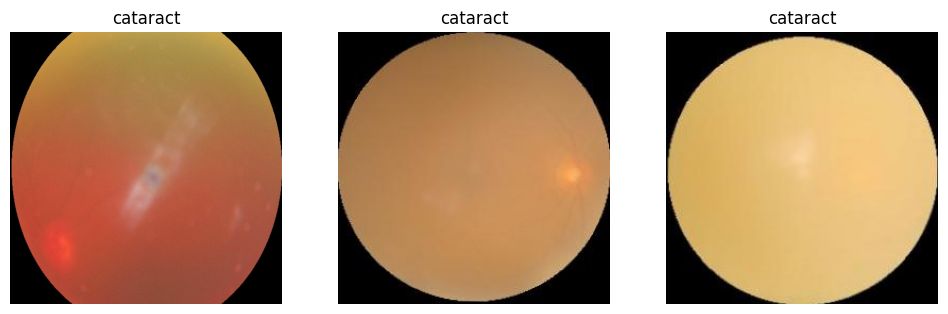

In [7]:
plot_image(0)

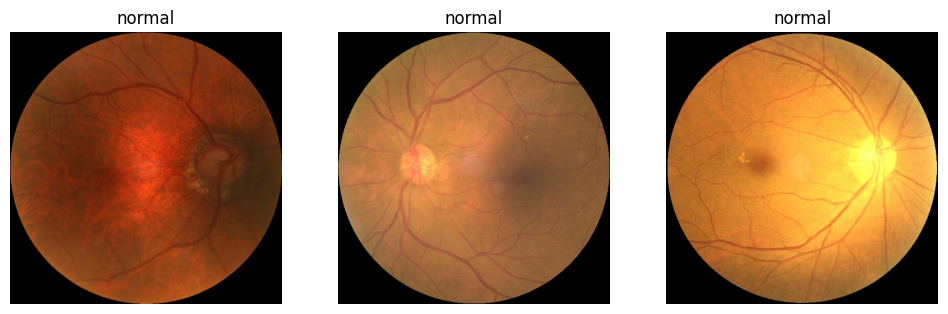

In [8]:
plot_image(1)

In [9]:
df['disease_type'] = df['disease_type'].map({0:'cataract',1:'normal'})

In [10]:
df.disease_type.value_counts()

disease_type
normal      1074
cataract    1038
Name: count, dtype: int64

In [11]:
# shuffling the rows of a DataFrame df
df1=df.sample(frac=1).reset_index(drop=True)

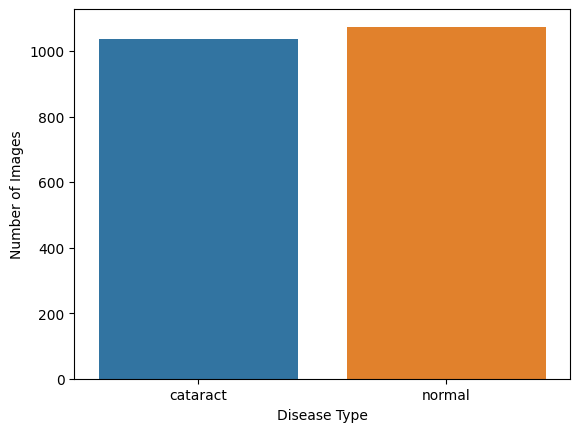

In [12]:
#custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

# Assuming 'df1' contains your DataFrame with 'disease_type' column
sns.countplot(x='disease_type', data=df1)
plt.xlabel('Disease Type')
plt.ylabel('Number of Images')

# Save the plot as an image 
plt.savefig('countplot.png')

plt.show()

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,BatchNormalization,MaxPooling2D,Conv2DTranspose,Activation
, Input,concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Add, DepthwiseConv2D,Flatten
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, RandomContrast, RandomRotation, RandomZoom, RandomFlip
from tensorflow.keras.utils import to_categorical, plot_model, image_dataset_from_directory

# Data Training& Testing

In [14]:
from sklearn.model_selection import train_test_split

# Split your data into features (X) and labels (y)
X = df1['image']  # 'image' contains image data
y = df1['disease_type']  # 'disease_type' contains labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2,rescale=1./255.)


In [16]:
# Data generators for training 
train_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = True,
                                          subset = 'training')

Found 1690 validated image filenames belonging to 2 classes.


In [17]:
# Data generators for validation
valid_data=datagen.flow_from_dataframe(dataframe=df1,
                                      x_col='image',
                                      y_col = 'disease_type',
                                      target_size = (224,224),
                                      class_mode= 'categorical',
                                      batch_size = 32,
                                      shuffle = False,
                                      subset= 'validation')

Found 422 validated image filenames belonging to 2 classes.


In [18]:
# Check if class indices are consistent
if (train_data.class_indices == valid_data.class_indices):

    # Print that the class indices are consistent
    print("Class indices are consistent")

    # Save class indices as metadata in metadata.js
    class_indices = train_data.class_indices
    print(class_indices)
    js_code = f"const classIndices = {class_indices};\nexport default classIndices;"
    with open('metadata.js', 'w') as f:
        f.write(js_code)
else:
    print("Class indices are not consistent")

Class indices are consistent
{'cataract': 0, 'normal': 1}


# Building The Model

In [19]:
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, RandomContrast, RandomRotation, RandomZoom, RandomFlip
from keras.models import Sequential


In [20]:
labels=[key for key in train_data.class_indices]
num_classes = len(disease_type)

In [21]:
from tensorflow.keras.applications.vgg19 import VGG19
image_size=224
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

80134624/80134624 [==============================] - 3s 0us/step


In [22]:
for layer in vgg.layers:
    layer.trainable = False

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(2,activation="sigmoid"))

In [24]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.binary_crossentropy, 
              metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
Total params: 20,074,562
Trainable params: 50,178
Non-trainable params: 20,024,384
_________________________________________________________________


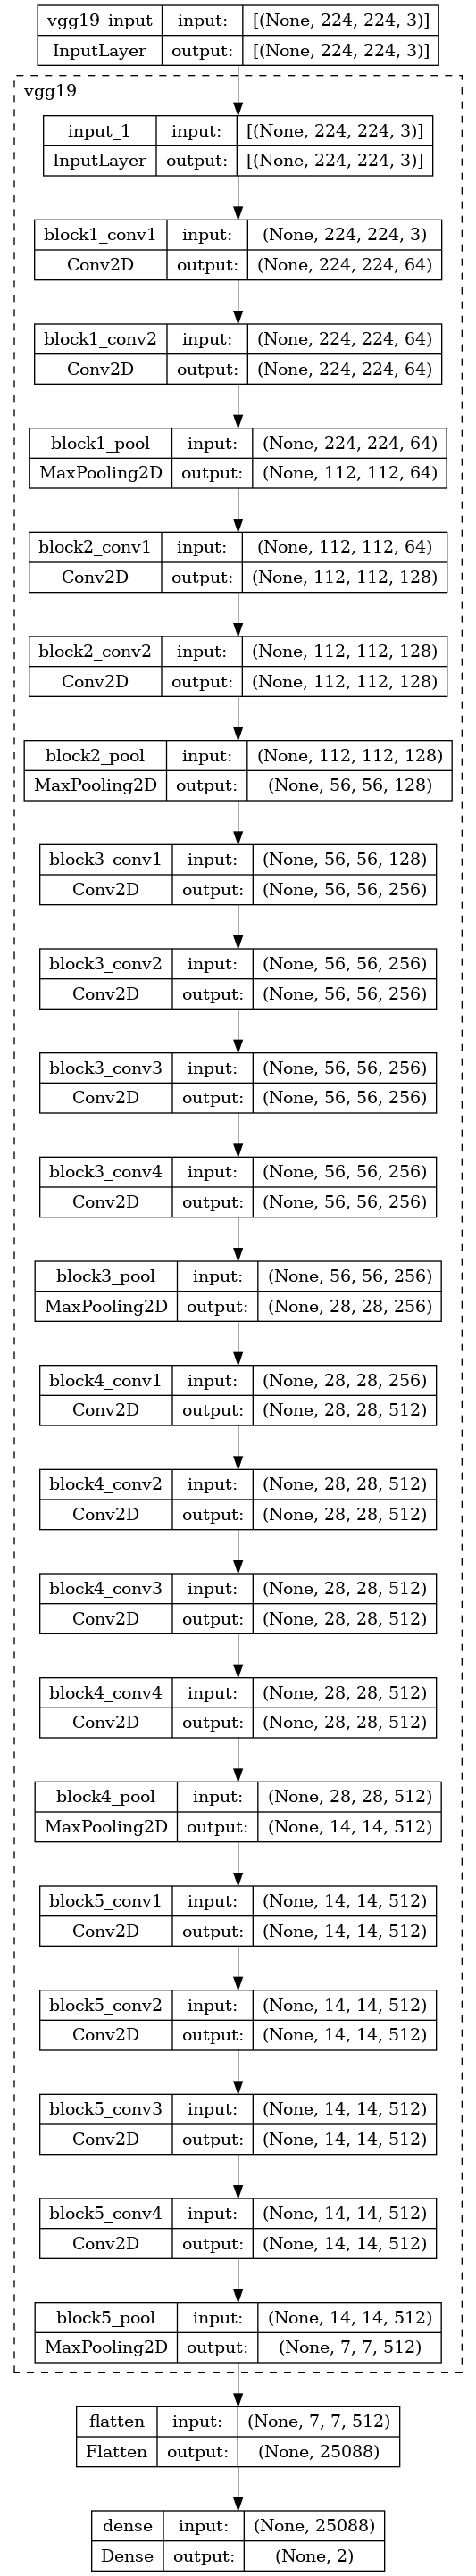

In [25]:
tf.keras.utils.plot_model(model,
                          to_file="model.png",
                          show_shapes=True,
                          expand_nested=True)

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [27]:
his = model.fit(
    train_data,       # Training data
    batch_size=32,    # Batch size for training
    epochs=15,        # Number of training epochs
    validation_data=valid_data,  # Validation data
    verbose=1,        # Verbosity level for training logs
    callbacks=[checkpoint, earlystop]  # Callback functions
)


Epoch 1/15
53/53 [==============================] - 41s 609ms/step - loss: 0.3090 - accuracy: 0.8592 - val_loss: 218.0036 - val_accuracy: 0.9265
Epoch 2/15
53/53 [==============================] - 17s 317ms/step - loss: 0.1620 - accuracy: 0.9379 - val_loss: 186.1909 - val_accuracy: 0.9431
Epoch 3/15
53/53 [==============================] - 17s 318ms/step - loss: 0.1381 - accuracy: 0.9462 - val_loss: 64.7052 - val_accuracy: 0.9360
Epoch 4/15
53/53 [==============================] - 17s 316ms/step - loss: 0.1091 - accuracy: 0.9586 - val_loss: 81.0734 - val_accuracy: 0.9479
Epoch 5/15
53/53 [==============================] - 17s 324ms/step - loss: 0.0964 - accuracy: 0.9675 - val_loss: 65.7497 - val_accuracy: 0.9502
Epoch 6/15
53/53 [==============================] - 17s 329ms/step - loss: 0.0887 - accuracy: 0.9680 - val_loss: 65.9746 - val_accuracy: 0.9573
Epoch 7/15
53/53 [==============================] - 17s 314ms/step - loss: 0.0847 - accuracy: 0.9716 - val_loss: 71.4035 - val_accurac

In [28]:

loss, accuracy = model.evaluate(valid_data)
print("Loss:", loss)
print("Accuracy:", accuracy)

14/14 [==============================] - 4s 252ms/step - loss: 57.7971 - accuracy: 0.9550
Loss: 57.797119140625
Accuracy: 0.9549763202667236


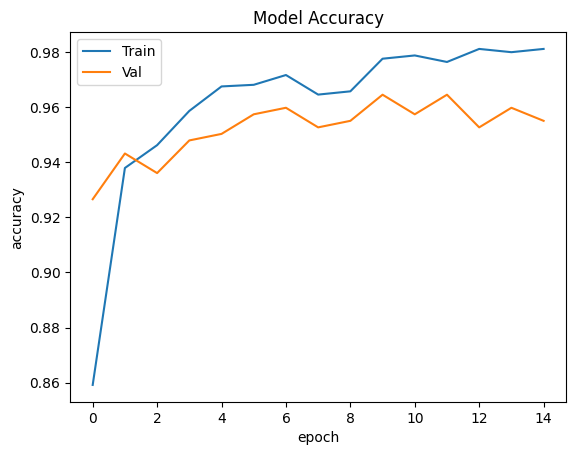

In [29]:
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

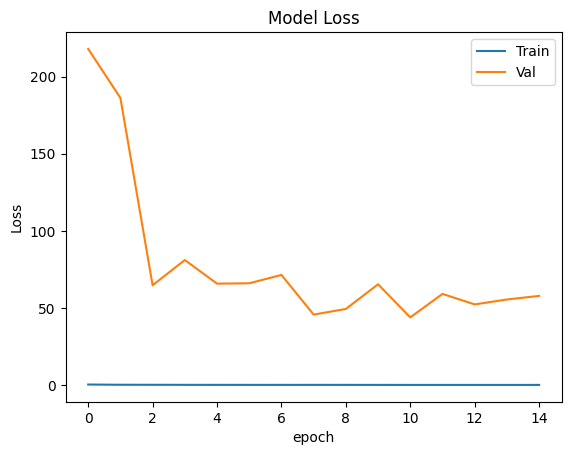

In [30]:
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

In [31]:
def tr_plot(tr_data, start_epoch):
    #Plot the loss and accuracy curve
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout

    plt.show()

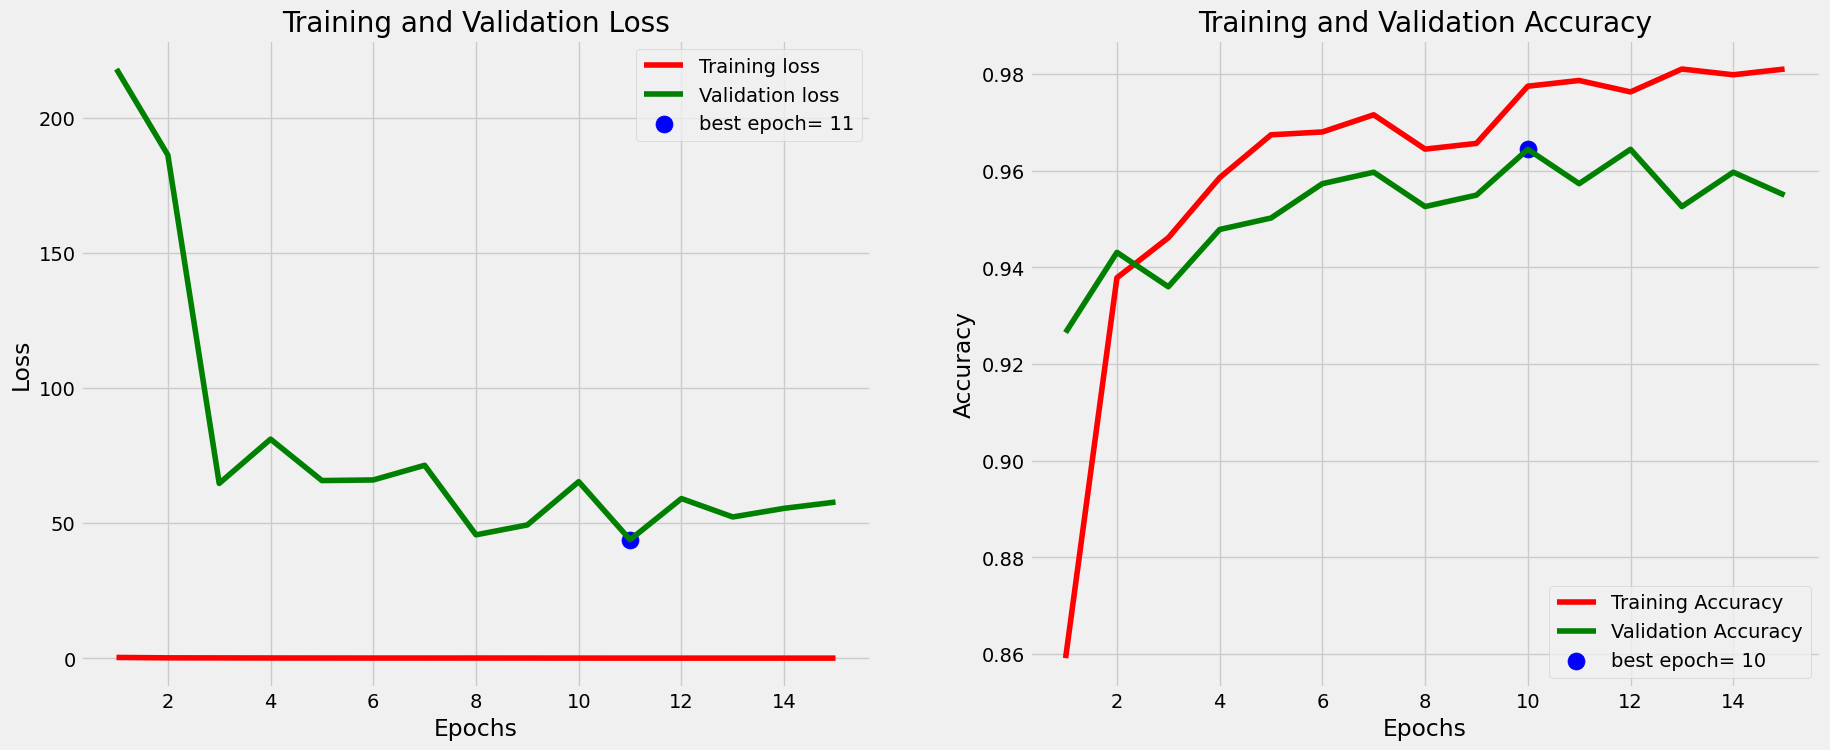

<Figure size 640x480 with 0 Axes>

In [32]:
# plot the history
tr_plot(his,0)
plt.savefig('history.png')


# Model Evaluation

In [33]:
y_test = valid_data.classes
y_pred = model.predict(valid_data)
y_pred = np.argmax(y_pred,axis=1)

14/14 [==============================] - 4s 240ms/step


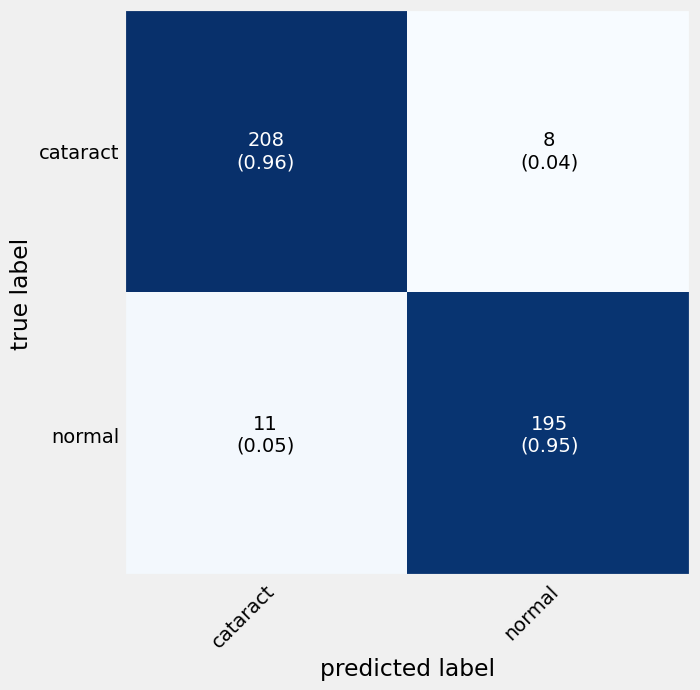

In [34]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = [ "cataract", "normal"],
                      show_normed = True);
plt.savefig("Predected & True Label")

In [35]:
def plot_image(n, num_samples=3):
    disease_labels = [ 'cataract', 'normal']
    filtered_data = df1[df1['disease_type'] == n]

    print(f"Number of available samples for {disease_labels[n-1]}: {len(filtered_data)}")

    if len(filtered_data) > num_samples:
        print(f"Randomly selecting {num_samples} samples.")
        images = filtered_data.sample(num_samples)['image']
    else:
        print(f"Using all available samples.")
        images = filtered_data['image']

    print(f"Number of selected samples: {len(images)}")

    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[n-1])  # Use n-1 to access the correct label

    plt.show()

plot_image(1)


Number of available samples for cataract: 0
Using all available samples.
Number of selected samples: 0


<Figure size 1200x1200 with 0 Axes>

In [36]:
print(classification_report(y_test,y_pred,target_names = labels))

              precision    recall  f1-score   support

    cataract       0.95      0.96      0.96       216
      normal       0.96      0.95      0.95       206

    accuracy                           0.95       422
   macro avg       0.96      0.95      0.95       422
weighted avg       0.96      0.95      0.95       422



1/1 [==============================] - 0s 185ms/step


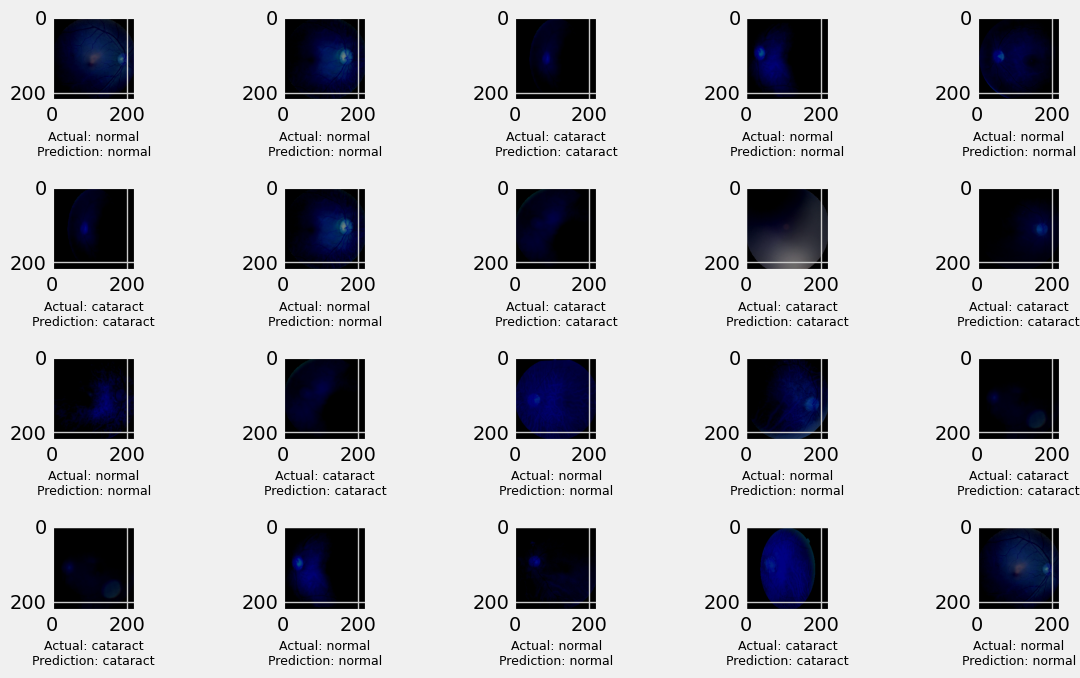

In [37]:
import random
import matplotlib.pyplot as plt

# Define the class labels
class_labels = [ "cataract", "normal"]

# Get a batch of data from the valid_data generator
images, labels = next(valid_data)

# Replace these variables with your actual data
y_pred = model.predict(images)  # Assuming you have a trained model

plt.figure(figsize=(12, 7))

for i in range(20):
    sample_index = random.randint(0, images.shape[0] - 1)
    image = images[sample_index]
    category_index = labels[sample_index].argmax()
    pred_category_index = y_pred[sample_index].argmax()

    label = class_labels[category_index]
    pred_label = class_labels[pred_category_index]

    plt.subplot(4, 5, i + 1)
    plt.imshow(image)
    
    # Change the font size for labels
    plt.xlabel("Actual: {}\nPrediction: {}".format(label, pred_label), fontsize=9)  # Change the fontsize as needed

plt.tight_layout()

# Save the plot as an image 
plt.savefig('Model Eval.png')

plt.show()

In [38]:
model.save("Eye Disease Classification")